In [1]:
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

idx = pd.IndexSlice

In [2]:
with open(Path.cwd().parent / 'config' / 'config.yaml') as f:
    colors = yaml.safe_load(f)['plotting']['tech_colors']

root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data"

In [3]:
regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")
    # ).set_crs("EPSG:3035")

In [4]:
n = pypsa.Network(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "dump" /
    "elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2035_chp_static_0.3_True.nc"
    )

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2035_chp_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
e = pd.read_csv(root / 'energy.csv', index_col=[0,1], header=list(range(9)))

In [6]:
load_grouper = {
    "electricity": [
        'electricity',
        'industry electricity',
        'land transport EV',
        ],
    "hydrogen": [
        "H2 for industry",
        "land transport fuel cell"
        ],
    "industry": [
        'naphtha for industry',
        'solid biomass for industry',
        'gas for industry',
        ],
    "transport": [
        'shipping methanol',
        'kerosene for aviation',
        ],
    "heat": [
        "urban central heat",
        "residential urban decentral heat",
        "residential rural heat",
        "low-temperature heat for industry",
        "services rural heat",
        "services urban decentral heat",
        ],
}

gen_grouper = {
    "solar thermal": [
        "residential rural solar thermal",
        "residential urban decentral solar thermal",
        "services rural solar thermal",
        "services urban decentral solar thermal",
        "urban central solar thermal",
        ], 
    "offshore wind": [
        "offwind-ac",
        "offwind-dc",
    ],
    "onshore wind": ["onwind"],
    "hydro": ["ror"],
    "gas": ["gas"],
    "geothermal heat": ["geothermal heat"],
    "oil": ["oil"],
    "solar": ["solar"],
    "solar rooftop": ["solar rooftop"],
}

nice_colors = {
    key: colors[carriers[0]] for key, carriers in load_grouper.items()
}
nice_gen_colors = {
    key: colors[carriers[0]] for key, carriers in gen_grouper.items()
}

In [7]:
i = idx['loads']

showyear = 2035
models = [
    idx[:,:,:,:,'2020','elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'dh','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'chp','static','0.3','True'],
]

In [8]:
import yaml
with open(Path.cwd().parent / 'config' / 'config.yaml') as f:
    tech_colors = yaml.safe_load(f)['plotting']['tech_colors']

In [9]:
ncosts = pd.read_csv(
    Path.cwd().parent.parent.parent /
    'cluster_data' /
    'breyer_sweep' /
    'joint_data' /
    'nodal_costs.csv',
    index_col=[0,1,2,3],
    header=list(range(9))
    )
ss = ncosts.loc[:,idx['72', 'v1.0', :, '2050', '2020', 'elec', 'static', '0.3', 'True']]
# print(ss.index.get_level_values(3).unique())
ss.loc[idx[:,:,'GB0 0','residential urban decentral gas boiler']]


cluster                                       72
ll                                          v1.0
opt              Co2L0-3H-T-H-B-I-solar+p3-dist1
planning_horizon                            2050
egs_capex                                   2020
egs_mode                                    elec
egs_op                                    static
progress                                     0.3
use_waste_heat                              True
links capital                       8.861103e+07
      marginal                      8.090504e+03

In [10]:
allnice_carriers = {
    'direct air capture': ['DAC'],
    'hydrogen production and storage': ['SMR CC', 'H2 Electrolysis', 'H2 Store', 'Sabatier'],
    'fuel synthesis': ["Fischer-Tropsch", "mathanolisation"],
    'battery': ['battery', 'battery charger'],
    'hydro': ['ror', 'PHS', 'hydro'],
    'distribution grid': ['electricity distribution grid'],
    'onshore wind': ['onwind'],
    'offshore wind': ['offwind-ac', 'offwind-dc'],
    'gas': [
        'OCGT',
        'urban central gas CHP',
        'residential urban decentral gas boiler',
        ],
    'biomass': [
        'residential urban decentral biomass boiler',
        'urban central solid biomass CHP CC'
        ],
    'other': ['other'],
    'heat pumps': [
        'residential rural ground heat pump',
        'residential urban decentral air heat pump',
        'services rural ground heat pump',
        'services urban decentral air heat pump',
        'urban central air heat pump',
        ],
    'solar': ['solar', 'solar rooftop'],
    'geothermal heat': ['geothermal heat'],
}
allnice_colors = {
    key: tech_colors[carriers[0]] for key, carriers in allnice_carriers.items()
}

0.5017535598895492


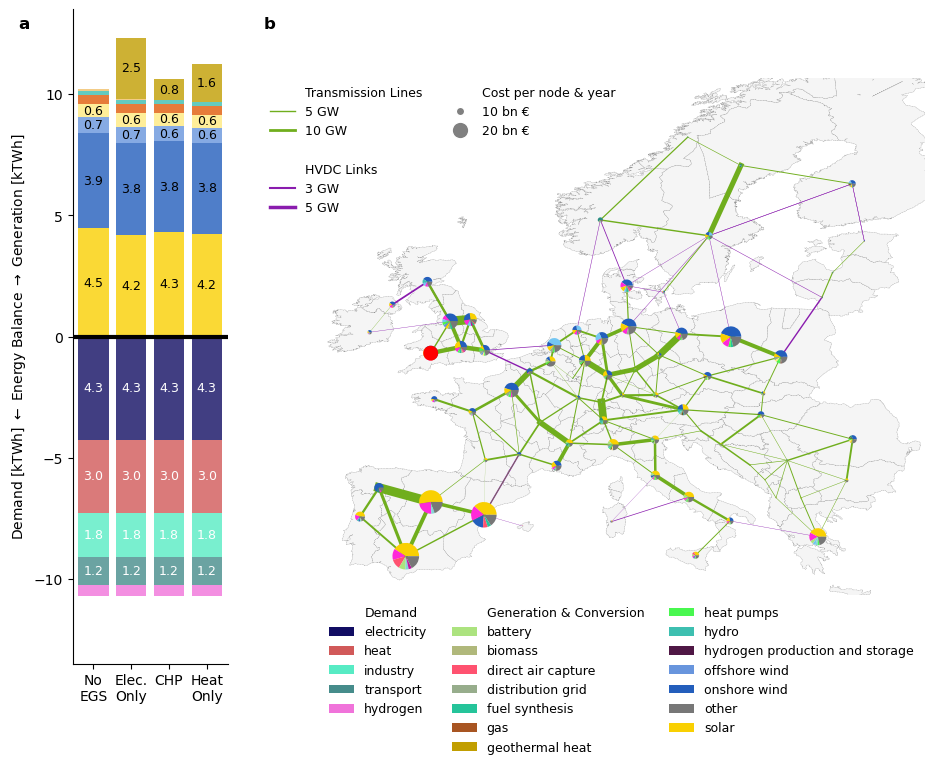

In [22]:
width = 0.8

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,4]}, figsize=(11, 8.5))

included = set()

for j, m in enumerate(models):
    load = e.loc[idx['loads'], m].iloc[:,0].mul(1e-9)
    nice_loads = pd.Series({nice_carr: load.loc[carriers].sum() for nice_carr, carriers in load_grouper.items()})

    if j == 0:
        order = nice_loads.sort_values(ascending=True).index
    
    nice_loads = nice_loads.loc[order]
    nice_loads_cumulative = nice_loads.cumsum()

    for nice_carr in order:

        value = nice_loads.loc[nice_carr]
        ceil = nice_loads_cumulative.loc[nice_carr]
        axs[0].bar(
            j,
            -value,
            color=nice_colors[nice_carr],
            bottom=ceil,
            width=width,
            alpha=0.8,
            )
        
        if abs(value) > 0.5:
            axs[0].text(
                j,
                ceil - value/2,
                f"{abs(value):.1f}",
                ha='center',
                va='center',
                color='white',
                fontsize=9,
                # fontweight='bold',
                )

    gen = e.loc[idx['generators'], m].iloc[:,0].mul(1e-9)
    nice_gens = pd.Series({nice_carr: gen.loc[carriers].sum() for nice_carr, carriers in gen_grouper.items()})

    if j == 0:
        gen_order = nice_gens.sort_values(ascending=False).index

    nice_gens = nice_gens.loc[gen_order]
    nice_gens_cumulative = nice_gens.cumsum()

    for nice_carr in gen_order:

        value = nice_gens.loc[nice_carr]
        ceil = nice_gens_cumulative.loc[nice_carr]
        axs[0].bar(
            j,
            -value,
            color=nice_gen_colors[nice_carr],
            bottom=ceil,
            width=width,
            alpha=0.8,
            )

        if abs(value) > 0.5:
            axs[0].text(
                j,
                ceil - value/2,
                f"{abs(value):.1f}",
                ha='center',
                va='center',
                color='k',
                fontsize=9,
                # fontweight='bold',
                )


axs[0].set_xlim(-width/2 - 0.15, len(models) - 1 + width/2 + 0.15)
axs[0].set_ylim(-13.5, 13.5)
axs[0].plot([-width/2 - 0.15, len(models) - 1 + width/2 + 0.15], [0, 0], color='black', lw=3)
axs[0].set_ylabel(r"Demand [kTWh] $\leftarrow$ Energy Balance $\rightarrow$ Generation [kTWh]")

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

regions.plot(
    ax=axs[1],
    color="whitesmoke",
    edgecolor="k",
    linewidth=0.2,
    alpha=1,
    label="name",
    zorder=0,
    linestyle=":",
    # linestyle=":"
    )

onegw_linkwidth = 0.5

for line in n.links.loc[n.links.carrier == 'DC'].iterrows():
    axs[1].plot(
        [n.buses.loc[line[1].bus0].x, n.buses.loc[line[1].bus1].x],
        [n.buses.loc[line[1].bus0].y, n.buses.loc[line[1].bus1].y],
        color='#8a1cae',
        lw=line[1].p_nom / 1000 * onegw_linkwidth,
        zorder=1,
        )

onegw_linewidth = 0.2

for line in n.lines.iterrows():
    axs[1].plot(
        [n.buses.loc[line[1].bus0].x, n.buses.loc[line[1].bus1].x],
        [n.buses.loc[line[1].bus0].y, n.buses.loc[line[1].bus1].y],
        color='#70ae1d',
        lw=line[1].s_nom/1000*onegw_linewidth,
        zorder=1,
        )

shown_carriers = pd.Index([])

for bus in ss.index.get_level_values(2).unique():
    # print(bus)

    if (
        isinstance(bus, float) or
        'EU' in bus or
        bus in ['gas for', 'process', 'solid']
    ):
        continue

    buss = (
        ss
        .loc[idx[:,:,bus,:]]
        .groupby(level=2).sum()
        .iloc[:,0]
        .sort_values(ascending=False)
    )

    buss.name = 'costs'

    share_threshold = 0.035
    total = buss.sum()
    show = buss.loc[buss > total * share_threshold]
    show.loc['other'] = buss.loc[buss <= total * share_threshold].sum()

    shown_carriers = shown_carriers.union(show.index)
    
    onebn_size = 0.05
    radius = show.sum() * 1e-9 * onebn_size / 2
    show /= total

    x, y = n.buses.loc[bus].x, n.buses.loc[bus].y

    axs[1].pie(
        show,
        radius=radius,
        colors=[tech_colors.get(c, 'grey') for c in show.index],
        center=(x, y),
    )


    if bus == 'GB0 3':
        axs[1].pie(
            [1],
            radius=radius,
            colors=['red'],
            center=(x, y),
        )

axs[0].spines['bottom'].set_visible(True)
axs[0].set_xticks(
    list(range(4)),
    [
        "No\nEGS",
        "Elec.\nOnly",
        "CHP",
        "Heat\nOnly",
    ],
    )

ss.loc[idx[:,:,'GB0 0','residential urban decentral gas boiler']]

axs[1].set_aspect('equal')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[1].set_xlim(-12, 30)
axs[1].set_ylim(35, 70)


trans_labels = [
    'Transmission Lines', '5 GW', '10 GW', '', 'HVDC Links', '3 GW', '5 GW',
    'Cost per node & year', '10 bn €', '20 bn €', '', '', '',
    ]

trans_handles = [
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='#70ae1d', lw=onegw_linewidth*5),
    Line2D([0], [0], color='#70ae1d', lw=onegw_linewidth*10),
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='#8a1cae', lw=onegw_linkwidth*3),
    Line2D([0], [0], color='#8a1cae', lw=onegw_linkwidth*5),
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='w', marker='o', markersize=6, markerfacecolor='grey'),
    Line2D([0], [0], color='w', marker='o', markersize=12, markerfacecolor='grey'),
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='w'),
    Line2D([0], [0], color='w'),
    ]


load_labels = list(nice_loads.index)
load_handles = [Patch(facecolor=nice_colors[l], label=l) for l in load_labels]

gen_labels = sorted(list(allnice_carriers.keys()))
gen_handles = [Patch(facecolor=allnice_colors[l], label=l) for l in gen_labels]

handles = [Line2D([0], [0], color='w')] + load_handles + 3*[Line2D([0], [0], color='w')] + gen_handles
labels = ["Demand"] + load_labels + ["", "", "Generation & Conversion"] + gen_labels

axs[1].legend(
    handles,
    labels,
    bbox_to_anchor=(1, -0.),
    frameon=False,
    fontsize=9,
    ncol=3,
    )

axs[0].legend(
    trans_handles,
    trans_labels,
    bbox_to_anchor=(1.2, 0.9),
    ncol=2,
    frameon=False,
    fontsize=9,
)

axs[0].text(
    -2,
    12.7,
    "a",
    fontsize=12,
    fontweight='bold'
    )
axs[0].text(
    4.5,
    12.7,
    "b",
    fontsize=12,
    fontweight='bold'
    )

# plt.tight_layout()
plt.savefig("intro_model_overview.pdf")
plt.show()